1 – MLP para problema logico XOR
- (a) Implemente uma rede neural sem camada oculta e observe se ela consegue aprender a funcao XOR.
- (b) Implemente uma rede com uma camada oculta de 4 neuronios e funcao de
ativacao Sigmoid. Treine com taxa de aprendizado α = 0,1 e 500 epocas.
- (c) Compare graficamente a acuracia de ambos os modelos e discuta a importancia
da nao-linearidade introduzida pela camada oculta.


In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Dados XOR
X = torch.tensor([[0., 0.], [0., 1.], [1., 0.], [1., 1.]])
y = torch.tensor([0., 1., 1., 0.]).reshape(-1, 1)

# Modelo sem camada oculta
model_no_hidden = nn.Sequential(
    nn.Linear(2, 1),
    nn.Sigmoid()
)

criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model_no_hidden.parameters(), lr=0.1)

# Treinamento
losses_no_hidden = []
for epoch in range(500):
    optimizer.zero_grad()
    outputs = model_no_hidden(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    losses_no_hidden.append(loss.item())

In [3]:
# Modelo com camada oculta
model_hidden = nn.Sequential(
    nn.Linear(2, 4),
    nn.Sigmoid(),
    nn.Linear(4, 1),
    nn.Sigmoid()
)

optimizer = torch.optim.SGD(model_hidden.parameters(), lr=0.1)
losses_hidden = []

for epoch in range(500):
    optimizer.zero_grad()
    outputs = model_hidden(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    losses_hidden.append(loss.item())

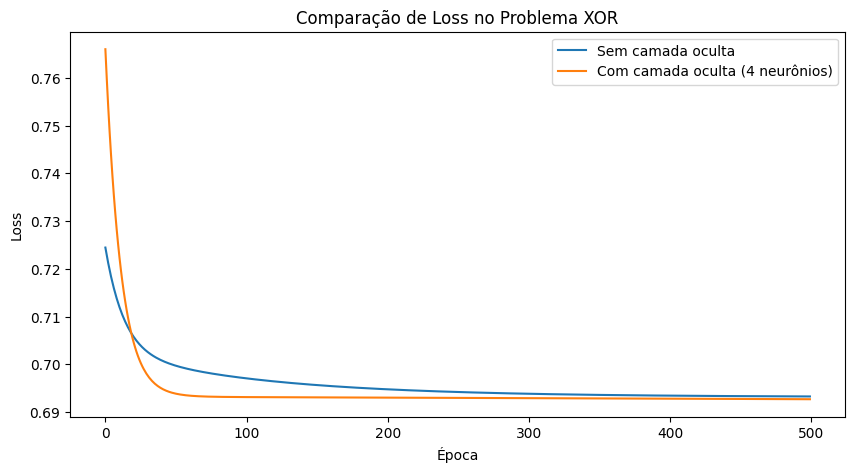

In [4]:
plt.figure(figsize=(10, 5))
plt.plot(losses_no_hidden, label='Sem camada oculta')
plt.plot(losses_hidden, label='Com camada oculta (4 neurônios)')
plt.title('Comparação de Loss no Problema XOR')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [5]:
#acuracia
with torch.no_grad():
    preds_no_hidden = (model_no_hidden(X) > 0.5).float()
    acc_no_hidden = (preds_no_hidden == y).float().mean()

print(f'Acurácia sem camada oculta: {acc_no_hidden.item()}')

Acurácia sem camada oculta: 0.5


2 – Variacao do numero de neuronios na camada escondida
Utilize o dataset Iris (com as 3 classes originais).
- (a) Implemente uma rede com apenas uma camada oculta variando o numero de
neuronios: 4, 8 e 16.
-  (b) Utilize ReLU como funcao de ativacao e mantenha o numero de epocas fixo em
100.
- (c) Plote as curvas de perda e acuracia para cada configuracao e discuta a relacao
entre capacidade da rede e desempenho.


In [6]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Carregar e preparar dados
iris = load_iris()
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

# Função para treinar e avaliar modelos
def train_model(hidden_size, epochs=100):
    model = nn.Sequential(
        nn.Linear(4, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, 3)
    )

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []

    for epoch in range(epochs):
        # Treino
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        # Acurácia treino
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == y_train).sum().item()
        train_accs.append(correct / len(y_train))

        # Teste
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            test_losses.append(test_loss.item())

            _, test_predicted = torch.max(test_outputs.data, 1)
            test_correct = (test_predicted == y_test).sum().item()
            test_accs.append(test_correct / len(y_test))

    return train_losses, test_losses, train_accs, test_accs

# Treinar modelos com diferentes tamanhos de camada oculta
hidden_sizes = [4, 8, 16]
results = {}
for size in hidden_sizes:
    results[size] = train_model(size)

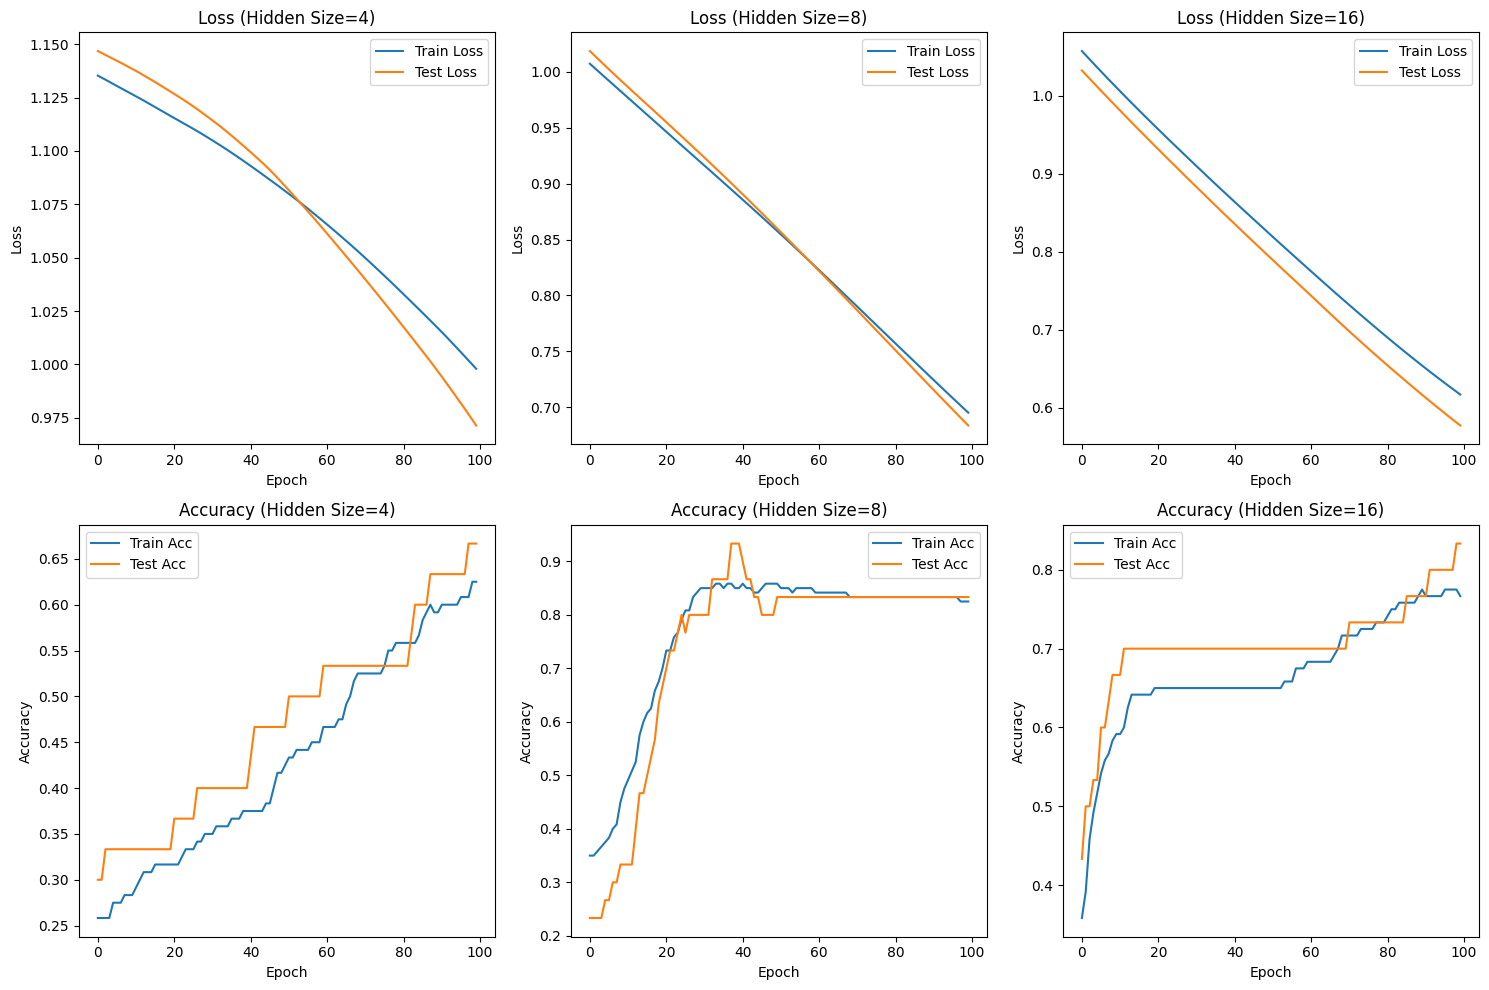

In [7]:
# Plotar resultados
plt.figure(figsize=(15, 10))

for i, size in enumerate(hidden_sizes):
    train_loss, test_loss, train_acc, test_acc = results[size]

    plt.subplot(2, 3, i+1)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(test_loss, label='Test Loss')
    plt.title(f'Loss (Hidden Size={size})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 3, i+4)
    plt.plot(train_acc, label='Train Acc')
    plt.plot(test_acc, label='Test Acc')
    plt.title(f'Accuracy (Hidden Size={size})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()

3 – Analise de funcoes de ativacao e epocas
Com base no modelo de melhor desempenho da questao anterior:
- (a) Treine a rede com diferentes funcoes de ativacao: Sigmoid, Tanh e ReLU.
- (b) Para cada funcao de ativacao, treine o modelo com 50, 100 e 300 epocas.
- (c) Analise graficamente as curvas de perda e acuracia e identifique as melhores
combinacoes. Comente sobre a velocidade de convergencia.


In [8]:
def train_model_activation(activation, epochs):
    if activation == 'Sigmoid':
        act_fn = nn.Sigmoid()
    elif activation == 'Tanh':
        act_fn = nn.Tanh()
    else:  # ReLU
        act_fn = nn.ReLU()

    model = nn.Sequential(
        nn.Linear(4, 8),  # Usando 8 neurônios (melhor resultado anterior)
        act_fn,
        nn.Linear(8, 3)
    )

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        # Treino
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        # Teste
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            test_losses.append(test_loss.item())

    return train_losses, test_losses

# Configurações a testar
activations = ['Sigmoid', 'Tanh', 'ReLU']
epochs_list = [50, 100, 300]
results_act = {}

for act in activations:
    for epochs in epochs_list:
        results_act[(act, epochs)] = train_model_activation(act, epochs)

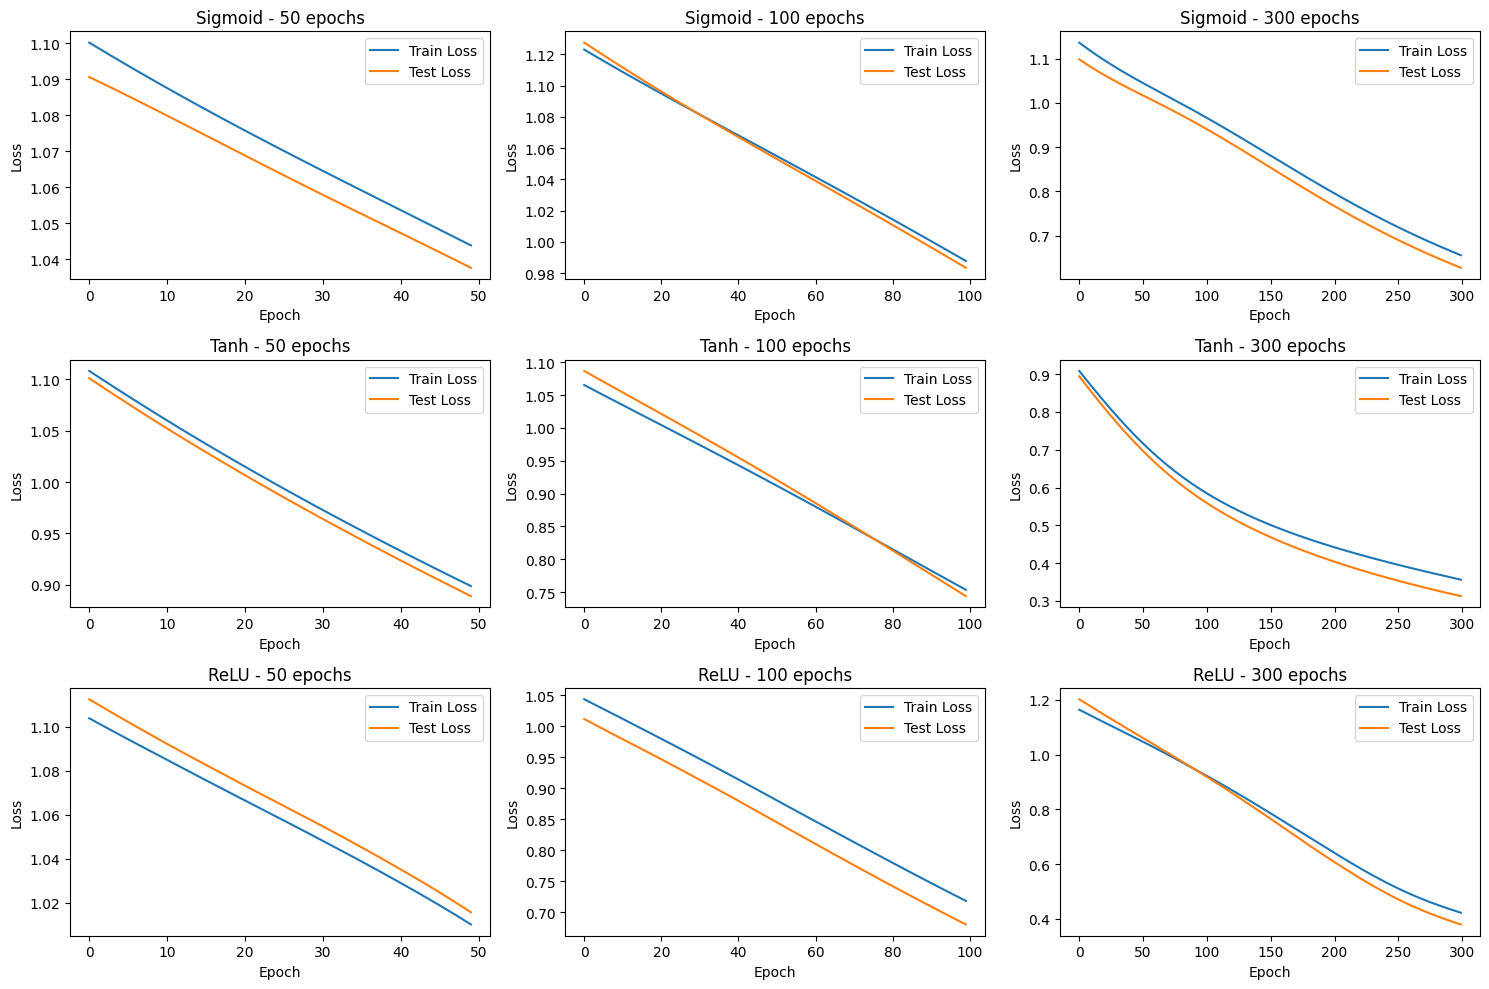

In [9]:
plt.figure(figsize=(15, 10))

for i, act in enumerate(activations):
    for j, epochs in enumerate(epochs_list):
        idx = i * len(epochs_list) + j + 1
        plt.subplot(3, 3, idx)

        train_loss, test_loss = results_act[(act, epochs)]
        plt.plot(train_loss, label='Train Loss')
        plt.plot(test_loss, label='Test Loss')
        plt.title(f'{act} - {epochs} epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

plt.tight_layout()
plt.show()